In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

In [52]:
df2024_1 = pd.read_parquet('../data/raw/yellow_tripdata_2024-01.parquet')
df2024_2 = pd.read_parquet('../data/raw/yellow_tripdata_2024-02.parquet')
df2024_3 = pd.read_parquet('../data/raw/yellow_tripdata_2024-03.parquet')
df2024_4 = pd.read_parquet('../data/raw/yellow_tripdata_2024-04.parquet')
df2024_5 = pd.read_parquet('../data/raw/yellow_tripdata_2024-05.parquet')
df2024_6 = pd.read_parquet('../data/raw/yellow_tripdata_2024-06.parquet')

df2024 = pd.concat([df2024_1, df2024_2, df2024_3, df2024_4, df2024_5, df2024_6])

In [53]:
df2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20332093 entries, 0 to 3539192
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            flo

In [54]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    'null_value(%)': df2024.isna().mean().values * 100,
    'neg_value(%)': [len(df2024[col][df2024[col] < 0]) / len(df2024) * 100 if col in df2024.select_dtypes(include=[np.number]).columns else 0 for col in df2024.columns],
    '0_value(%)': [len(df2024[col][df2024[col] == 0]) / len(df2024) * 100 if col in df2024.select_dtypes(include=[np.number]).columns else 0 for col in df2024.columns],
    'duplicate' : df2024.duplicated().sum(),
    'min': [df2024[col].min() if col in df2024.select_dtypes(include=[np.number]).columns else None for col in df2024.columns],
    'max': [df2024[col].max() if col in df2024.select_dtypes(include=[np.number]).columns else None for col in df2024.columns],
    'n_unique': df2024.nunique().values,
    'sample_unique': [df2024[col].unique() for col in df2024.columns]}
).round(3)

,feature,data_type,null_value(%),neg_value(%),0_value(%),duplicate,min,max,n_unique,sample_unique
0,VendorID,int32,0.000,0.000,0.000,1,1.00,6.00,3,"[2, 1, 6]"
1,tpep_pickup_datetime,datetime64[us],0.000,0.000,0.000,1,NaN,NaN,9955675,"[2024-01-01 00:57:55, 2024-01-01 00:03:00, 202..."
2,tpep_dropoff_datetime,datetime64[us],0.000,0.000,0.000,1,NaN,NaN,9948395,"[2024-01-01 01:17:43, 2024-01-01 00:09:36, 202..."
3,passenger_count,float64,9.719,0.000,1.087,1,0.00,9.00,10,"[1.0, 2.0, 0.0, 4.0, 3.0, 5.0, 6.0, 8.0, 7.0, ..."
4,trip_distance,float64,0.000,0.000,1.792,1,0.00,312722.30,7056,"[1.72, 1.8, 4.7, 1.4, 0.8, 10.82, 3.0, 5.44, 0..."
5,RatecodeID,float64,9.719,0.000,0.000,1,1.00,99.00,7,"[1.0, 5.0, 2.0, 4.0, 99.0, 3.0, 6.0, nan]"
6,store_and_fwd_flag,object,9.719,0.000,0.000,1,NaN,NaN,2,"[N, Y, None]"
7,PULocationID,int32,0.000,0.000,0.000,1,1.00,265.00,262,"[186, 140, 236, 79, 211, 148, 138, 246, 161, 1..."
8,DOLocationID,int32,0.000,0.000,0.000,1,1.00,265.00,261,"[79, 236, 211, 148, 141, 181, 231, 261, 113, 1..."
9,payment_type,int64,0.000,0.000,9.719,1,0.00,5.00,6,"[2, 1, 4, 3, 0, 5]"


### Handling Duplicates

In [55]:
df2024[df2024.duplicated()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
754252,2,2024-02-08 18:23:50,2024-02-08 18:38:14,1.0,0.81,1.0,N,162,230,1,12.8,2.5,0.5,3.86,0.0,1.0,23.16,2.5,0.0


In [56]:
df2024.drop_duplicates(inplace= True)

In [57]:
duplicate_value = df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)]
duplicate_value

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
99,2,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,N,249,232,4,-13.50,-1.0,-0.5,0.0,0.0,-1.0,-18.50,-2.5,0.00
100,2,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,N,249,232,4,13.50,1.0,0.5,0.0,0.0,1.0,18.50,2.5,0.00
506,2,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,5.0,N,63,63,2,-31.50,0.0,0.0,0.0,0.0,-1.0,-34.25,0.0,-1.75
507,2,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,5.0,N,63,63,2,31.50,0.0,0.0,0.0,0.0,1.0,34.25,0.0,1.75
536,2,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,1.0,N,249,113,4,-5.80,-1.0,-0.5,0.0,0.0,-1.0,-10.80,-2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341361,2,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,NaN,None,50,186,0,19.48,0.0,0.5,0.0,0.0,1.0,23.48,NaN,NaN
3372158,2,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,NaN,None,151,74,0,18.92,0.0,0.5,0.0,0.0,1.0,20.42,NaN,NaN
3372569,2,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,NaN,None,231,68,0,17.37,0.0,0.5,0.0,0.0,1.0,21.37,NaN,NaN
3405783,2,2024-06-21 18:55:00,2024-06-21 19:11:00,NaN,2.21,NaN,None,234,163,0,18.11,0.0,0.5,0.0,0.0,1.0,22.11,NaN,NaN


In [58]:
dup_negative_val = duplicate_value[duplicate_value['fare_amount']<0]
dup_negative_val 

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
99,2,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,N,249,232,4,-13.5,-1.0,-0.5,0.0,0.00,-1.0,-18.50,-2.5,0.00
506,2,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,5.0,N,63,63,2,-31.5,0.0,0.0,0.0,0.00,-1.0,-34.25,0.0,-1.75
536,2,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,1.0,N,249,113,4,-5.8,-1.0,-0.5,0.0,0.00,-1.0,-10.80,-2.5,0.00
552,2,2024-01-01 00:42:02,2024-01-01 01:14:33,1.0,5.48,1.0,N,107,61,2,-33.1,-1.0,-0.5,0.0,0.00,-1.0,-38.10,-2.5,0.00
682,2,2024-01-01 00:24:02,2024-01-01 01:10:32,1.0,8.74,1.0,N,90,225,4,-47.8,-1.0,-0.5,0.0,0.00,-1.0,-52.80,-2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128236,2,2024-06-30 23:03:55,2024-06-30 23:12:30,3.0,0.91,1.0,N,230,162,4,-6.5,-1.0,-0.5,0.0,0.00,-1.0,-11.50,-2.5,0.00
3128264,2,2024-06-30 23:47:55,2024-07-01 00:36:20,2.0,5.38,1.0,N,186,256,4,-43.6,-1.0,-0.5,0.0,0.00,-1.0,-48.60,-2.5,0.00
3128357,2,2024-06-30 23:19:00,2024-06-30 23:54:15,2.0,17.77,2.0,N,132,230,4,-70.0,0.0,-0.5,0.0,-6.94,-1.0,-82.69,-2.5,-1.75
3128387,2,2024-06-30 23:47:08,2024-06-30 23:47:13,1.0,0.00,5.0,N,138,138,3,-86.0,-5.0,-0.5,0.0,0.00,-1.0,-92.50,0.0,0.00


In [59]:
df2024.drop(dup_negative_val.index, inplace=True)

In [60]:
df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
6956,2,2024-01-01 01:53:45,2024-01-01 02:25:58,1.0,2.97,1.0,N,170,50,2,0.00,0.0,0.5,0.0,0.0,1.0,4.00,2.5,0.0
15731,2,2024-01-01 02:15:52,2024-01-01 02:46:49,2.0,8.86,1.0,N,246,133,2,0.00,0.0,0.5,0.0,0.0,1.0,4.00,2.5,0.0
20848,2,2024-01-01 04:28:12,2024-01-01 04:28:27,1.0,0.00,5.0,N,265,265,2,0.00,0.0,0.5,0.0,0.0,1.0,1.50,0.0,0.0
20850,2,2024-01-01 04:29:46,2024-01-01 04:30:01,1.0,0.00,5.0,N,265,265,2,0.00,0.0,0.0,0.0,0.0,1.0,1.00,0.0,0.0
40344,2,2024-01-01 14:57:35,2024-01-01 14:57:46,1.0,0.00,1.0,N,132,132,2,0.00,0.0,0.5,0.0,0.0,1.0,1.50,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3269203,2,2024-06-09 12:40:00,2024-06-09 13:06:00,NaN,4.54,NaN,None,116,142,0,27.44,0.0,0.5,0.0,0.0,1.0,31.44,NaN,NaN
3320358,2,2024-06-14 18:49:00,2024-06-14 19:05:00,NaN,2.60,NaN,None,162,239,0,20.86,0.0,0.5,0.0,0.0,1.0,24.86,NaN,NaN
3341361,2,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,NaN,None,50,186,0,19.48,0.0,0.5,0.0,0.0,1.0,23.48,NaN,NaN
3372569,2,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,NaN,None,231,68,0,17.37,0.0,0.5,0.0,0.0,1.0,21.37,NaN,NaN


In [61]:
df2024.drop_duplicates(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance'], keep=False)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3539188,2,2024-06-30 23:07:36,2024-06-30 23:18:35,NaN,2.51,NaN,None,255,148,0,21.09,0.0,0.5,0.00,0.0,1.0,25.09,NaN,NaN
3539189,2,2024-06-30 23:46:07,2024-07-01 00:11:53,NaN,7.55,NaN,None,68,74,0,33.96,0.0,0.5,0.00,0.0,1.0,37.96,NaN,NaN
3539190,2,2024-06-30 23:18:50,2024-06-30 23:35:09,NaN,4.25,NaN,None,41,100,0,21.01,0.0,0.5,0.00,0.0,1.0,25.01,NaN,NaN
3539191,1,2024-06-30 23:33:36,2024-06-30 23:42:37,NaN,1.60,NaN,None,158,231,0,14.41,0.0,0.5,0.00,0.0,1.0,18.41,NaN,NaN


In [40]:
df2024[df2024.duplicated(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime',  'passenger_count', 'trip_distance'])]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount
6956,2024-01-01 01:53:45,2024-01-01 02:25:58,1.0,2.97,0.00,4.00
15731,2024-01-01 02:15:52,2024-01-01 02:46:49,2.0,8.86,0.00,4.00
20848,2024-01-01 04:28:12,2024-01-01 04:28:27,1.0,0.00,0.00,1.50
20850,2024-01-01 04:29:46,2024-01-01 04:30:01,1.0,0.00,0.00,1.00
40344,2024-01-01 14:57:35,2024-01-01 14:57:46,1.0,0.00,0.00,1.50
...,...,...,...,...,...,...
3269203,2024-06-09 12:40:00,2024-06-09 13:06:00,NaN,4.54,27.44,31.44
3320358,2024-06-14 18:49:00,2024-06-14 19:05:00,NaN,2.60,20.86,24.86
3341361,2024-06-16 00:27:00,2024-06-16 00:36:00,NaN,1.88,19.48,23.48
3372569,2024-06-18 16:51:00,2024-06-18 17:09:00,NaN,2.66,17.37,21.37


In [62]:
df2024 = df2024[~df2024.index.duplicated(keep='first')]

## Negative Values

In [63]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'neg_value(%)': [len(df2024[col][df2024[col] < 0]) / len(df2024) * 100 if np.issubdtype(df2024[col].dtype, np.number) else 0 for col in df2024.columns]
}).round(3)

,feature,neg_value(%)
0,VendorID,0.000
1,tpep_pickup_datetime,0.000
2,tpep_dropoff_datetime,0.000
3,passenger_count,0.000
4,trip_distance,0.000
5,RatecodeID,0.000
6,store_and_fwd_flag,0.000
7,PULocationID,0.000
8,DOLocationID,0.000
9,payment_type,0.000


In [64]:
negative_val  = df2024[df2024['fare_amount']<0]
df2024.loc[negative_val.index, 'fare_amount'] = df2024['fare_amount'].abs()

## Zero Values

In [65]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    '0_value(%)': [len(df2024[col][df2024[col] == 0]) / len(df2024) * 100 if np.issubdtype(df2024[col].dtype, np.number) else 0 for col in df2024.columns]
}).round(3)

,feature,data_type,0_value(%)
0,VendorID,int32,0.000
1,tpep_pickup_datetime,datetime64[us],0.000
2,tpep_dropoff_datetime,datetime64[us],0.000
3,passenger_count,float64,0.893
4,trip_distance,float64,3.213
5,RatecodeID,float64,0.000
6,store_and_fwd_flag,object,0.000
7,PULocationID,int32,0.000
8,DOLocationID,int32,0.000
9,payment_type,int64,21.194


In [66]:
median_passenger_count = df2024[df2024['passenger_count'] > 0]['passenger_count'].median()
df2024['passenger_count'] = df2024['passenger_count'].apply(lambda x: x if (x > 0 )  else median_passenger_count)

df2024 = df2024[df2024['trip_distance']>0]
df2024 = df2024[df2024['fare_amount']>0]

## Missing Values


In [67]:
pd.DataFrame({
    'feature': df2024.columns.values,
    'data_type': df2024.dtypes.values,
    'null_value(%)': df2024.isna().mean().values * 100
}).round(3)

,feature,data_type,null_value(%)
0,VendorID,int32,0.000
1,tpep_pickup_datetime,datetime64[us],0.000
2,tpep_dropoff_datetime,datetime64[us],0.000
3,passenger_count,float64,0.000
4,trip_distance,float64,0.000
5,RatecodeID,float64,19.555
6,store_and_fwd_flag,object,19.555
7,PULocationID,int32,0.000
8,DOLocationID,int32,0.000
9,payment_type,int64,0.000


In [68]:
df2024['passenger_count'].fillna(df2024['passenger_count'].median(), inplace=True)
df2024['passenger_count'].value_counts()

C:\Users\Dipika Bogati\AppData\Local\Temp\ipykernel_30316\2787419272.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2024['passenger_count'].fillna(df2024['passenger_count'].median(), inplace=True)


passenger_count
1.0    2772489
2.0     393796
3.0      90759
4.0      51868
5.0      32447
6.0      21571
8.0         35
7.0          5
9.0          1
Name: count, dtype: int64

In [69]:
outliers = df2024[(df2024['tpep_pickup_datetime'].dt.year!=2024)]
outliers

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
256,2,2023-12-31 23:56:46,2024-01-01 00:12:06,2.0,2.38,1.0,N,236,142,1,15.6,1.00,0.5,1.00,0.00,1.0,21.60,2.5,0.00
369,2,2023-12-31 23:39:17,2023-12-31 23:42:00,2.0,0.47,1.0,N,90,68,1,5.1,1.00,0.5,0.00,0.00,1.0,10.10,2.5,0.00
2210,2,2023-12-31 23:57:17,2024-01-01 00:01:50,1.0,0.53,1.0,N,144,211,1,5.8,1.00,0.5,2.16,0.00,1.0,12.96,2.5,0.00
2615,2,2023-12-31 23:56:45,2024-01-01 00:00:28,1.0,0.97,1.0,N,163,237,1,6.5,1.00,0.5,2.00,0.00,1.0,13.50,2.5,0.00
2985,2,2023-12-31 23:49:12,2024-01-01 00:04:32,1.0,3.14,1.0,N,234,237,1,17.0,1.00,0.5,6.60,0.00,1.0,28.60,2.5,0.00
3176,2,2023-12-31 23:47:28,2023-12-31 23:57:07,2.0,1.44,1.0,N,68,137,1,10.7,1.00,0.5,3.14,0.00,1.0,18.84,2.5,0.00
4137,2,2023-12-31 23:58:35,2024-01-01 00:13:06,6.0,8.39,1.0,N,138,217,2,33.1,6.00,0.5,0.00,0.00,1.0,42.35,0.0,1.75
4142,2,2023-12-31 23:58:37,2024-01-01 00:08:37,2.0,0.59,1.0,N,161,170,1,10.0,1.00,0.5,3.75,0.00,1.0,18.75,2.5,0.00
8628,2,2023-12-31 23:54:27,2024-01-01 00:13:12,1.0,7.70,1.0,N,229,244,1,33.1,1.00,0.5,7.62,0.00,1.0,45.72,2.5,0.00
10915,2,2009-01-01 23:58:40,2009-01-02 00:01:40,1.0,0.46,1.0,N,137,264,2,4.4,3.50,0.5,0.00,0.00,1.0,9.40,0.0,0.00


In [70]:
df2024.drop(outliers.index, inplace=True)

In [71]:
df2024[(df2024['tpep_pickup_datetime'].dt.year!=2024)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee


In [72]:
time_bins = [0, 5, 11, 15, 20, 24] 
time_labels = ['Midnight', 'Morning', 'Noon', 'Evening', 'Night']
df2024['pickup_time'] = pd.cut(df2024['tpep_pickup_datetime'].dt.hour, bins=time_bins, labels=time_labels, right=False)

df2024['day_category'] = df2024['tpep_pickup_datetime'].dt.day_name().apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekdays')

### Trip Distance

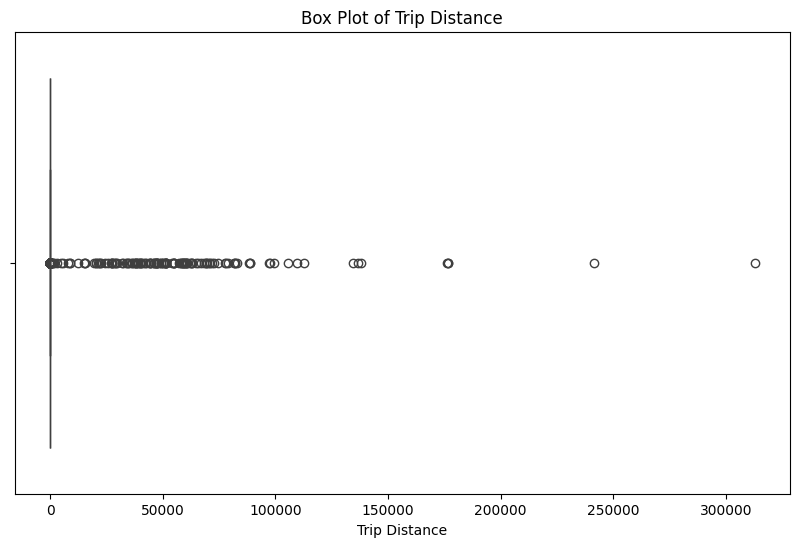

In [73]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2024['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

In [74]:
df2024 = df2024[df2024['trip_distance']>1]

In [75]:
df2024[df2024['trip_distance']>120].sort_values(by='trip_distance', ascending=False).shape

(155, 21)

In [76]:
df2024 = df2024[df2024['trip_distance']<120]

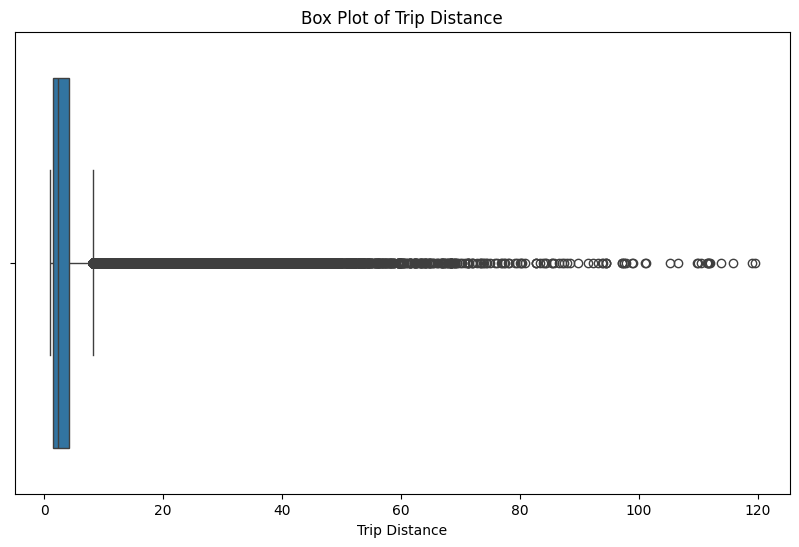

In [77]:
# Create a boxplot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2024['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()

### Fare Amount

In [78]:
df2024[df2024['fare_amount']>120].sort_values(by='trip_distance', ascending=False).head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_time,day_category
2522757,2,2024-01-28 17:24:07,2024-01-28 19:50:30,1.0,119.46,4.0,N,132,265,2,...,0.0,0.0,0.0,29.26,1.0,771.41,0.0,1.75,Evening,Weekend
2362433,2,2024-01-27 01:30:01,2024-01-27 03:53:02,1.0,118.99,5.0,N,48,265,1,...,0.0,0.0,0.0,0.00,1.0,261.00,0.0,0.00,Midnight,Weekend
770905,2,2024-01-10 11:14:43,2024-01-10 13:06:29,2.0,115.75,5.0,N,132,265,2,...,0.0,0.0,0.0,6.94,1.0,409.69,0.0,1.75,Noon,Weekdays
2933532,2,2024-01-24 23:00:52,2024-01-25 00:58:13,1.0,111.95,NaN,None,164,265,0,...,0.0,0.0,0.0,13.38,1.0,312.99,NaN,NaN,Night,Weekdays
2609633,2,2024-01-29 19:58:16,2024-01-29 21:54:55,4.0,111.77,5.0,N,132,265,1,...,0.0,0.0,0.1,0.00,1.0,402.85,0.0,1.75,Evening,Weekdays


### Feature Creation -- trip_duration

In [79]:
diff = (df2024['tpep_dropoff_datetime'] - df2024['tpep_pickup_datetime']).dt.total_seconds()/60
df2024['trip_duration'] = diff.round(2)

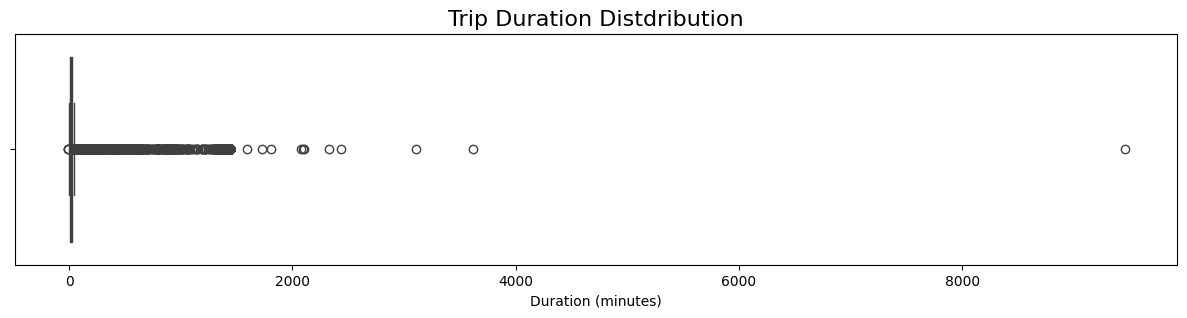

In [80]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2024, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

 With the furthest recorded distance, which is 114 miles, when traveled at the lowest average speed in New York City, which is 10 mph, the time required would be 11.4 hours (or about 684 minutes). Therefore, any trip duration exceeding this calculated time can be considered an extreme outlier, as it would be unusually long for a taxi ride. Based on this, any records with durations significantly exceeding 684 minutes can be flagged as extreme outliers, suggesting that these values are likely unnatural or erroneous.

In [81]:
df2024[df2024['trip_duration']>700].sort_values(by='trip_duration', ascending=False).head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_time,day_category,trip_duration
2111505,2,2024-01-24 17:03:14,2024-01-31 06:38:38,1.0,2.26,1.0,N,237,170,2,...,0.5,0.0,0.00,1.0,36.80,2.5,0.00,Evening,Weekdays,9455.40
942462,2,2024-01-12 01:20:50,2024-01-14 13:42:36,1.0,35.70,3.0,N,132,42,2,...,0.0,0.0,27.26,1.0,181.41,0.0,1.75,Midnight,Weekdays,3621.77
1159593,2,2024-01-14 10:08:11,2024-01-16 13:54:22,1.0,31.95,1.0,N,220,220,2,...,0.5,0.0,0.00,1.0,2225.30,2.5,0.00,Morning,Weekend,3106.18
2219253,2,2024-01-25 18:53:29,2024-01-27 11:32:13,1.0,4.56,1.0,N,140,133,2,...,0.5,0.0,0.00,1.0,28.40,2.5,0.00,Evening,Weekdays,2438.73
3042904,2,2024-03-30 18:57:53,2024-04-01 09:42:39,1.0,36.96,1.0,N,231,231,2,...,0.5,0.0,0.00,1.0,150.50,2.5,0.00,Evening,Weekend,2324.77


In [82]:
df2024 = df2024[df2024['trip_duration']<700]

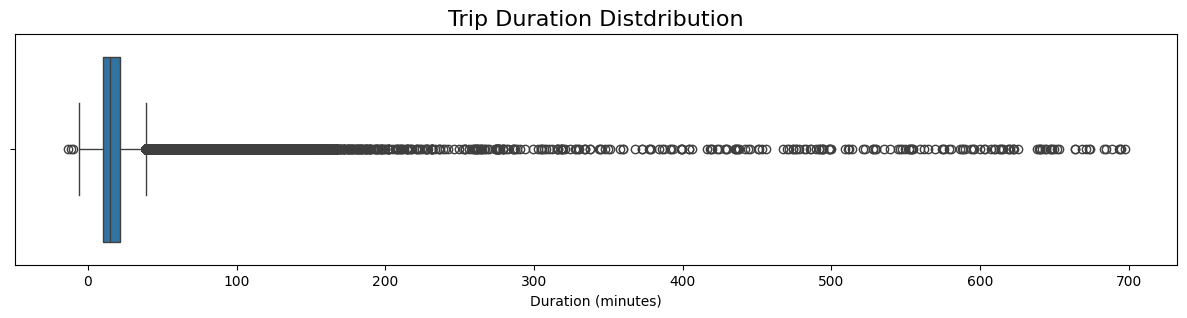

In [83]:
plt.figure(figsize=(15, 3))

sns.boxplot(data=df2024, x='trip_duration')
plt.xlabel('Duration (minutes)')
plt.title('Trip Duration Distdribution', fontsize=16)


plt.show()

In [85]:
def downcast_dtypes(df):
    # Downcast numerical columns to save memory
    float_cols = df.select_dtypes(include=['float64']).columns
    int_cols = df.select_dtypes(include=['int64']).columns

    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)

    return df

def preprocess_data(df):
    # for NaN value
    df['passenger_count'] = pd.to_numeric(df['passenger_count'], errors='coerce')
    df['RatecodeID'] = pd.to_numeric(df['RatecodeID'], errors='coerce')
    df['congestion_surcharge'] = pd.to_numeric(df['congestion_surcharge'], errors='coerce')
    df['Airport_fee'] = pd.to_numeric(df['Airport_fee'], errors='coerce')
    
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    imputer = SimpleImputer(strategy='median')
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
    
    # Downcast dtypes
    df = downcast_dtypes(df)
    
    # Feature Engineering
    df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour
    df['pickup_day'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.day_name()
    df['pickup_month'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.month
    
    # Encode categorical variables
    categorical_columns = ['pickup_day', 'RatecodeID']
    df = pd.get_dummies(df, columns=categorical_columns)
    
    return df


In [86]:
df = preprocess_data(df2024)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2612379 entries, 0 to 3723832
Data columns (total 37 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float32       
 4   trip_distance          float32       
 5   store_and_fwd_flag     object        
 6   PULocationID           int32         
 7   DOLocationID           int32         
 8   payment_type           float32       
 9   fare_amount            float32       
 10  extra                  float32       
 11  mta_tax                float32       
 12  tip_amount             float32       
 13  tolls_amount           float32       
 14  improvement_surcharge  float32       
 15  total_amount           float32       
 16  congestion_surcharge   float32       
 17  Airport_fee            float32       
 18  pickup_time            cate

In [87]:
missing_values = df.columns[df.isnull().sum() > 0]
print(missing_values)

Index(['store_and_fwd_flag'], dtype='object')


In [88]:
X = df[['passenger_count', 'trip_distance','PULocationID', 'DOLocationID', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee']]
y = df['payment_type']
missing_values = df.columns[df.isnull().sum() > 0]
print(missing_values)

Index(['store_and_fwd_flag'], dtype='object')


In [ ]:
# Compute Mutual Information Scores
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)


In [ ]:
# Display MI Scores
print("Mutual Information Scores:")
print(mi_scores.sort_values(ascending=False))


In [ ]:
# Split into features and target
X = df[['tip_amount', 'congestion_surcharge', 'total_amount', 'improvement_surcharge', 'mta_tax', 'VendorID', 'passenger_count']]  # Replace 'payment_type' with your target column name
y = df['payment_type']

In [ ]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=20,random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

In [ ]:
# for XGboost, the index should start from 0
if y.min() != 0:
    y = y - y.min()  # Reindex to start from 0

In [ ]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {model_name: {"accuracy": [], "f1_score": []} for model_name in models}

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Evaluate metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass
        
        results[model_name]["accuracy"].append(acc)
        results[model_name]["f1_score"].append(f1)

# Display average metrics for each model
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
    print(f"Average F1-Score: {np.mean(metrics['f1_score']):.4f}")

In [ ]:
# Visualizing the distributions of metrics (accuracy, precision, f1 score) for each model
metrics_to_plot = ['accuracy', 'f1_score']

plt.figure(figsize=(16, 12))

plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data={model_name: metrics[metric] for model_name, metrics in results.items()})
    plt.title(f'Distribution of {metric.capitalize()}')
    plt.xlabel('Model')
    plt.ylabel(metric.capitalize())

plt.tight_layout()
plt.show()